In [13]:
file_to_check = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data/hrrr_uv_agl_2024_08.nc" # Or any other file

# --- 3. Extract coordinates and compare ---
with xr.open_dataset(file_to_check) as ds:
    print((ds['u'].sel(height_m=40) != ds['u'].sel(height_m=140)).any().compute())
    print((ds['v'].sel(height_m=40) != ds['v'].sel(height_m=140)).any().compute())
    print(ds)

<xarray.DataArray 'u' ()>
array(True)
Coordinates:
    latitude   float64 41.17
    longitude  float64 -71.58
<xarray.DataArray 'v' ()>
array(True)
Coordinates:
    latitude   float64 41.17
    longitude  float64 -71.58
<xarray.Dataset>
Dimensions:    (time: 744, height_m: 2)
Coordinates:
  * time       (time) datetime64[ns] 2024-08-01 ... 2024-08-31T23:00:00
  * height_m   (height_m) int64 40 140
    latitude   float64 ...
    longitude  float64 ...
Data variables:
    u          (time, height_m) float64 ...
    v          (time, height_m) float64 ...


In [85]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("--- Cell 1: Setup Complete ---")
print("Libraries imported.")

# --- File Paths and Parameters ---
# Path to your HRRR data directory
HRRR_DIR = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data"

# List of the HRRR files you are currently analyzing
HRRR_FILES = [
    "hrrr_uv_agl_2022_08.nc", "hrrr_uv_agl_2022_09.nc", "hrrr_uv_agl_2022_10.nc",
    "hrrr_uv_agl_2022_11.nc", "hrrr_uv_agl_2022_12.nc", "hrrr_uv_agl_2023_01.nc",
    "hrrr_uv_agl_2023_02.nc", "hrrr_uv_agl_2023_03.nc", "hrrr_uv_agl_2023_04.nc",
    "hrrr_uv_agl_2023_05.nc", "hrrr_uv_agl_2023_06.nc", "hrrr_uv_agl_2023_07.nc",
    "hrrr_uv_agl_2023_08.nc", "hrrr_uv_agl_2023_09.nc", "hrrr_uv_agl_2023_10.nc",
    "hrrr_uv_agl_2023_11.nc",

    "hrrr_uv_agl_2023_12.nc", "hrrr_uv_agl_2024_01.nc", "hrrr_uv_agl_2024_02.nc", 
    "hrrr_uv_agl_2024_02.nc", "hrrr_uv_agl_2024_03.nc", "hrrr_uv_agl_2024_04.nc", 
    "hrrr_uv_agl_2024_05.nc", "hrrr_uv_agl_2024_06.nc", "hrrr_uv_agl_2024_07.nc", 
    "hrrr_uv_agl_2024_08.nc", "hrrr_uv_agl_2024_09.nc", "hrrr_uv_agl_2024_10.nc", 
    "hrrr_uv_agl_2024_11.nc", "hrrr_uv_agl_2024_12.nc", "hrrr_uv_agl_2025_01.nc", 
    "hrrr_uv_agl_2025_02.nc", "hrrr_uv_agl_2025_03.nc", "hrrr_uv_agl_2025_04.nc", 
    "hrrr_uv_agl_2025_05.nc", "hrrr_uv_agl_2025_06.nc"
]

# Combine directory and file names
hrrr_filepaths = [os.path.join(HRRR_DIR, f) for f in HRRR_FILES]

print(f"Configuration loaded for {len(hrrr_filepaths)} files.")

--- Cell 1: Setup Complete ---
Libraries imported.
Configuration loaded for 36 files.


In [87]:
# --- Load and Combine Data ---
# Use open_mfdataset to efficiently load multiple files
print("--- Cell 2: Loading Data ---")
# Using combine='by_coords' is generally robust for time-series data
ds = xr.open_mfdataset(hrrr_filepaths, combine='by_coords')

# Display the structure of the dataset to verify coordinate and variable names
# IMPORTANT: Check this output to confirm names like 'latitude', 'longitude', 
# 'height', 'u-component_of_wind_height_above_ground', etc.
print("\n--- Dataset Structure ---")
print(ds)
print("\n--- Data Loading Complete ---")

--- Cell 2: Loading Data ---

--- Dataset Structure ---
<xarray.Dataset>
Dimensions:    (time: 24984, height_m: 2)
Coordinates:
  * time       (time) datetime64[ns] 2022-08-01 ... 2025-06-30T23:00:00
  * height_m   (height_m) int64 40 140
    latitude   (time) float64 36.36 36.36 36.36 36.36 ... 41.17 41.17 41.17
    longitude  (time) float64 -97.51 -97.51 -97.51 ... -71.58 -71.58 -71.58
Data variables:
    u          (time, height_m) float64 dask.array<chunksize=(744, 2), meta=np.ndarray>
    v          (time, height_m) float64 dask.array<chunksize=(744, 2), meta=np.ndarray>

--- Data Loading Complete ---


In [117]:
# --- Define Analysis Point and Filter Data ---
print("--- Cell 3: Filtering Data ---")


# Filter the dataset to only include hours where the time is 10:00 UTC
# The `drop=True` removes all timestamps that don't match
ds_10utc = ds.where(ds.time.dt.hour == 2, drop=True)
time = '2:00'

# Select the data for the nearest grid point to your target lat/lon and height
# This creates a time-series for a single point.


print("\n--- Filtered Data Preview ---")
print(ds_10utc)

--- Cell 3: Filtering Data ---

--- Filtered Data Preview ---
<xarray.Dataset>
Dimensions:    (time: 1041, height_m: 2)
Coordinates:
  * time       (time) datetime64[ns] 2022-08-01T02:00:00 ... 2025-06-30T02:00:00
  * height_m   (height_m) int64 40 140
    latitude   (time) float64 36.36 36.36 36.36 36.36 ... 41.17 41.17 41.17
    longitude  (time) float64 -97.51 -97.51 -97.51 ... -71.58 -71.58 -71.58
Data variables:
    u          (time, height_m) float64 dask.array<chunksize=(31, 2), meta=np.ndarray>
    v          (time, height_m) float64 dask.array<chunksize=(31, 2), meta=np.ndarray>


--- Cell 4: Calculating and Plotting with Site Shading ---
[9.28868793 9.28868793 9.28868793 ... 9.28868793 9.28868793 9.28868793]
[11.04829225 11.04829225 11.04829225 ... 11.04829225 11.04829225
 11.04829225]
<xarray.DataArray (time: 1041, height_m: 2)>
dask.array<sqrt, shape=(1041, 2), dtype=float64, chunksize=(31, 2), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2022-08-01T02:00:00 ... 2025-06-30T02:00:00
  * height_m   (height_m) int64 40 140
    latitude   (time) float64 36.36 36.36 36.36 36.36 ... 41.17 41.17 41.17
    longitude  (time) float64 -97.51 -97.51 -97.51 ... -71.58 -71.58 -71.58


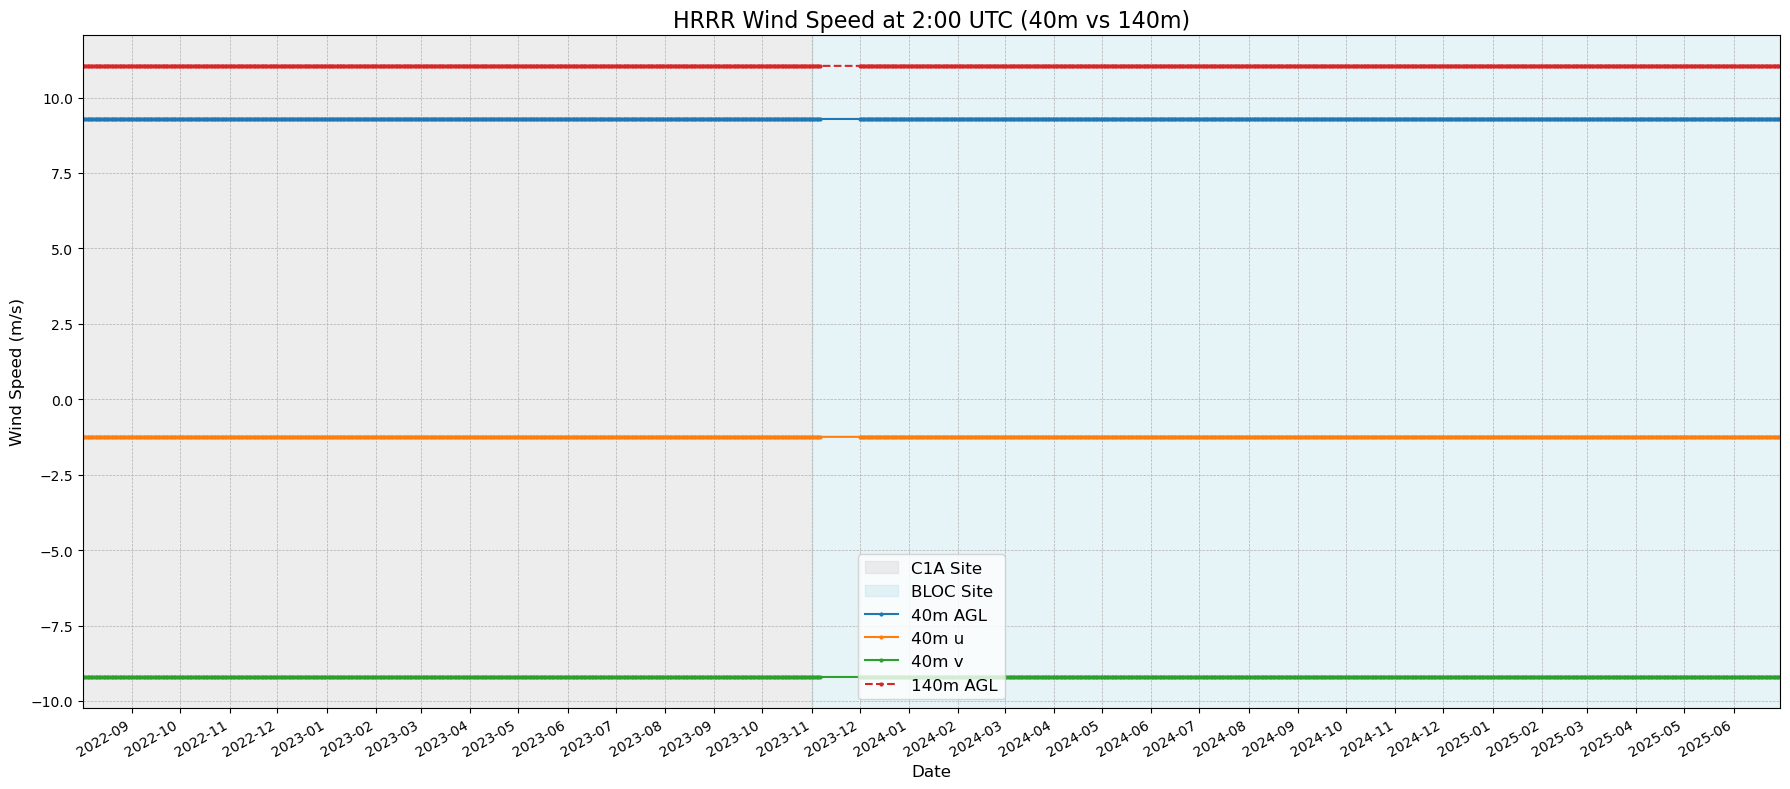


--- Plot Generated ---


In [131]:
# --- Cell 4 (Modified): Calculate, Plot, and Add Shaded Regions ---
print("--- Cell 4: Calculating and Plotting with Site Shading ---")

# First, we calculate wind speed on the data that still contains both height levels.
# This results in a 2D DataArray: (time, height_m)
u_component = ds_10utc['u']
v_component = ds_10utc['v']
wind_speed_2d = np.sqrt(u_component**2 + v_component**2)

# --- Create the Plot ---
fig, ax = plt.subplots(figsize=(18, 8))

# --- Add Shaded Regions for Sites ---
# This should be done BEFORE plotting the lines, so the lines appear on top.
shade_boundary = pd.to_datetime("2023-11-01")
plot_start_date = wind_speed_2d.time.min().values
plot_end_date = wind_speed_2d.time.max().values

# Shade the "C1A site" period
ax.axvspan(plot_start_date, shade_boundary, color='lightgray', alpha=0.4, label='C1A Site')

# Shade the "BLOC site" period
ax.axvspan(shade_boundary, plot_end_date, color='lightblue', alpha=0.3, label='BLOC Site')

# --- Plotting Each Height Level ---
# 1. Select and plot the 40m data
ws_40m = wind_speed_2d.sel(height_m=40)
print(ws_40m.values)
ax.plot(ws_40m.time, ws_40m.values, linestyle='-', marker='.', markersize=4, label='40m AGL')
ax.plot(u_component.sel(height_m=40).time, u_component.sel(height_m=40).values, linestyle='-', marker='.', markersize=4, label='40m u')
ax.plot(v_component.sel(height_m=40).time, v_component.sel(height_m=40).values, linestyle='-', marker='.', markersize=4, label='40m v')

# 2. Select and plot the 140m data
ws_140m = wind_speed_2d.sel(height_m=140)
print(ws_140m.values)
ax.plot(ws_140m.time, ws_140m.values, linestyle='--', marker='.', markersize=4, label='140m AGL')


# --- Formatting ---
lat_for_title = wind_speed_2d.latitude[0].item()
lon_for_title = wind_speed_2d.longitude[0].item()
print(wind_speed_2d)

ax.set_title(f"HRRR Wind Speed at {time} UTC (40m vs 140m)", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Wind Speed (m/s)", fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend to distinguish the lines AND shaded regions
ax.legend(fontsize=12)

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(plot_start_date, plot_end_date) # Ensure x-axis limits are tight
fig.autofmt_xdate() # Rotates and aligns the date labels

plt.tight_layout()
plt.show()

print("\n--- Plot Generated ---")

--- Generating mean diurnal cycle plot for C1A site ---
Filtering for the first location found: (36.36N, -97.51W)

--- Final Diurnal-Averaged Data Structure ---
<xarray.DataArray (hour: 24, height_m: 2)>
dask.array<stack, shape=(24, 2), dtype=float64, chunksize=(1, 2), chunktype=numpy.ndarray>
Coordinates:
  * height_m  (height_m) int64 40 140
  * hour      (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23


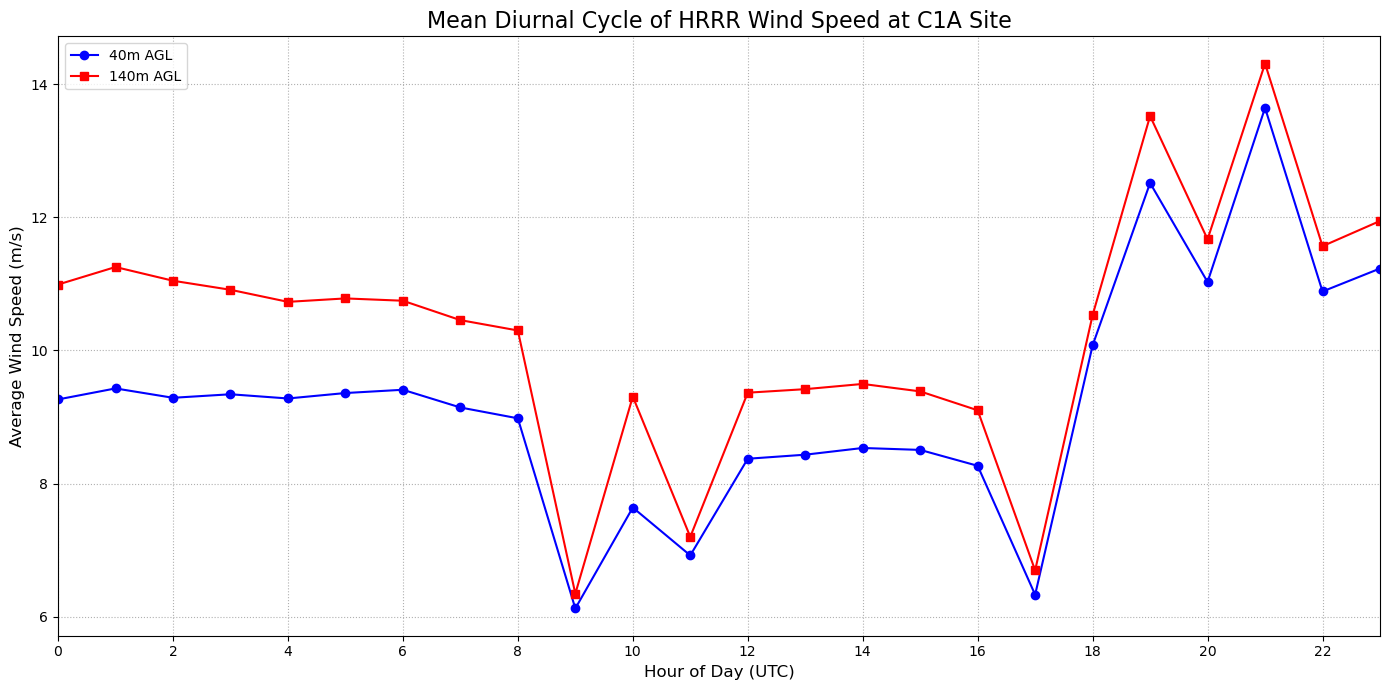


--- Diurnal Cycle Plot Generated ---


In [77]:
# --- Plot Mean Diurnal Cycle of Wind Speed for C1A Site ---
print("--- Generating mean diurnal cycle plot for C1A site ---")

# --- 1. Define C1A Site Parameters ---
C1A_END_DATE = '2023-11-30'

# --- 2. Filter for the C1A Time Period ---
ds_c1a_period = ds.sel(time=slice(None, C1A_END_DATE))

# --- 3. Create a Robust Location Mask ---
target_lat = ds_c1a_period.latitude.values[0]
target_lon = ds_c1a_period.longitude.values[0]
print(f"Filtering for the first location found: ({target_lat:.2f}N, {target_lon:.2f}W)")

mask_lat = (ds_c1a_period.latitude == target_lat)
mask_lon = (ds_c1a_period.longitude == target_lon)
c1a_location_mask = mask_lat & mask_lon
ds_c1a_point = ds_c1a_period.where(c1a_location_mask, drop=True)

# --- 4. Check for Data, Calculate Wind Speed, and Group by Hour ---
if ds_c1a_point.time.size == 0:
    print(f"ERROR: No data found for the target site.")
else:
    # --- Calculate instantaneous wind speed ---
    u_c1a = ds_c1a_point['u']
    v_c1a = ds_c1a_point['v']
    wind_speed_c1a = np.sqrt(u_c1a**2 + v_c1a**2)
    
    # --- NEW: Group data by the hour of the day and calculate the mean ---
    # This is the xarray equivalent of your pandas example
    wind_speed_diurnal = wind_speed_c1a.groupby('time.hour').mean()
    print("\n--- Final Diurnal-Averaged Data Structure ---")
    print(wind_speed_diurnal)

    # --- 5. Create the Diurnal Plot ---
    fig, ax = plt.subplots(figsize=(14, 7))

    # Select data for each height from the diurnal average
    ws_40m_diurnal = wind_speed_diurnal.sel(height_m=40)
    ws_140m_diurnal = wind_speed_diurnal.sel(height_m=140)

    # Plot both lines on the single axis
    ax.plot(ws_40m_diurnal.hour, ws_40m_diurnal.values, 'o-', label='40m AGL', color='blue')
    ax.plot(ws_140m_diurnal.hour, ws_140m_diurnal.values, 's-', label='140m AGL', color='red')

    # --- 6. Formatting ---
    ax.set_title(f"Mean Diurnal Cycle of HRRR Wind Speed at C1A Site", fontsize=16)
    ax.set_xlabel('Hour of Day (UTC)', fontsize=12)
    ax.set_ylabel('Average Wind Speed (m/s)', fontsize=12)
    ax.set_xticks(range(0, 24, 2))  # Set x-ticks to be every 2 hours
    ax.set_xlim(0, 23)              # Ensure x-axis spans the full day
    ax.grid(True, linestyle=':')
    ax.legend()

    plt.tight_layout()
    plt.show()

    print("\n--- Diurnal Cycle Plot Generated ---")

--- Checking C1A Dataset (before 2023-12-01) ---
Found C1A site location: (36.36N, -97.51W)


NotImplementedError: 'item' is not yet a valid method on dask arrays

In [9]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("--- Cell 1: Setup Complete ---")
print("Libraries imported.")

# --- File Paths and Parameters ---
# Path to your HRRR data directory
HRRR_DIR = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data"

# List of the HRRR files for the BLOC period
HRRR_FILES = [
    #"hrrr_uv_agl_2022_08.nc", "hrrr_uv_agl_2022_09.nc", "hrrr_uv_agl_2022_10.nc",
    #"hrrr_uv_agl_2022_11.nc", "hrrr_uv_agl_2022_12.nc", "hrrr_uv_agl_2023_01.nc",
    #"hrrr_uv_agl_2023_02.nc", "hrrr_uv_agl_2023_03.nc", "hrrr_uv_agl_2023_04.nc",
    #"hrrr_uv_agl_2023_05.nc", "hrrr_uv_agl_2023_06.nc", "hrrr_uv_agl_2023_07.nc",
    #"hrrr_uv_agl_2023_08.nc", "hrrr_uv_agl_2023_09.nc", "hrrr_uv_agl_2023_10.nc",
    #"hrrr_uv_agl_2023_11.nc",

    "hrrr_uv_agl_2023_12.nc", "hrrr_uv_agl_2024_01.nc", "hrrr_uv_agl_2024_02.nc", 
    "hrrr_uv_agl_2024_02.nc", "hrrr_uv_agl_2024_03.nc", "hrrr_uv_agl_2024_04.nc", 
    "hrrr_uv_agl_2024_05.nc", "hrrr_uv_agl_2024_06.nc", "hrrr_uv_agl_2024_07.nc", 
    "hrrr_uv_agl_2024_08.nc", "hrrr_uv_agl_2024_09.nc", "hrrr_uv_agl_2024_10.nc", 
    "hrrr_uv_agl_2024_11.nc", "hrrr_uv_agl_2024_12.nc", "hrrr_uv_agl_2025_01.nc", 
    "hrrr_uv_agl_2025_02.nc", "hrrr_uv_agl_2025_03.nc", "hrrr_uv_agl_2025_04.nc", 
    "hrrr_uv_agl_2025_05.nc", "hrrr_uv_agl_2025_06.nc"
]

# Path to your processed Lidar data
#LIDAR_FILE_PATH = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A"
LIDAR_FILE_PATH = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data"

# --- Analysis Period and Heights ---
BLOC_START_DATE = "2023-12-01"
BLOC_END_DATE = "2025-01-24"

# Combine directory and file names
hrrr_filepaths = [os.path.join(HRRR_DIR, f) for f in HRRR_FILES]

print(f"Configuration loaded for BLOC period: {BLOC_START_DATE} to {BLOC_END_DATE}")


--- Cell 1: Setup Complete ---
Libraries imported.
Configuration loaded for BLOC period: 2023-12-01 to 2025-01-24


In [7]:
print("\n--- Cell 2: Loading Processed Lidar Data ---")

try:
    # Load the pre-processed Lidar data from your other notebook
    df_lidar_analysis = pd.read_csv(LIDAR_PROCESSED_FILE)
    
    # Ensure the 'time' column is in datetime format
    df_lidar_analysis['time'] = pd.to_datetime(df_lidar_analysis['time'])    
    
    print("Successfully loaded and standardized processed Lidar data.")
    print(df_lidar_analysis.head())

except FileNotFoundError:
    print(f"Error: Processed Lidar file not found at '{LIDAR_PROCESSED_FILE}'")
    print("Please run your C1A processing notebook first to save the file.")
    df_lidar_analysis = pd.DataFrame() # Create empty df to avoid errors



--- Cell 2: Loading Processed Lidar Data ---


NameError: name 'LIDAR_PROCESSED_FILE' is not defined

In [11]:
print("\n--- Cell 3: Processing HRRR Data (Direct Selection Method) ---")
print("\n========== CURRENTLY U AND V COMPONENTS ARE THE SAME AT 40 M AND 140 M ===============")
print("if the return is False, all u and v componenets are the same at these two heights")
# Check if the u or v values at 40 and 140 are always the same --> THEY ARE RIGHT NOW
print((ds_hrrr['u'].sel(height_m=40) != ds_hrrr['u'].sel(height_m=140)).any().compute())
print((ds_hrrr['v'].sel(height_m=40) != ds_hrrr['v'].sel(height_m=140)).any().compute())

print("\n\n\n\n")

# Open multiple netCDF files as a single dataset
ds_hrrr = xr.open_mfdataset(hrrr_filepaths, combine='by_coords')

# Filter for the C1A deployment period first
ds_hrrr = ds_hrrr.sel(time=slice(BLOC_START_DATE, BLOC_END_DATE))
print(ds_hrrr['u'].coords)

heights_to_select = [40, 140]
ds_hrrr_selected = ds_hrrr.sel(height_m=heights_to_select)

# calculate wind speed and direction from the selected u and v components.
u_selected = ds_hrrr_selected['u']
v_selected = ds_hrrr_selected['v']

wspd_hrrr = np.sqrt(u_selected**2 + v_selected**2)
wspd_hrrr.attrs['units'] = 'm/s'
wspd_hrrr.attrs['long_name'] = 'Wind Speed'

wdir_hrrr = (270 - np.rad2deg(np.arctan2(v_selected, u_selected))) % 360
wdir_hrrr.attrs['units'] = 'degrees'
wdir_hrrr.attrs['long_name'] = 'Wind Direction'

# Add the calculated speed and direction back to the selected dataset
ds_hrrr_selected['wspd_hrrr'] = wspd_hrrr
ds_hrrr_selected['wdir_hrrr'] = wdir_hrrr

# Convert the final, calculated variables to a pandas DataFrame
df_hrrr = ds_hrrr_selected[['wspd_hrrr', 'wdir_hrrr']].to_dataframe().reset_index()
df_hrrr = df_hrrr.rename(columns={'height_m': 'height'})

print("HRRR wind speed and direction processed for selected heights.")
print(df_hrrr.head())




--- Cell 3: Processing HRRR Data (Direct Selection Method) ---

========== CURRENTLY U AND V COMPONENTS ARE THE SAME AT 40 M AND 140 M ===============
if the return is False, all u and v componenets are the same at these two heights


NameError: name 'ds_hrrr' is not defined

In [186]:
SHEAR_VEER_LOWER_H = 40
SHEAR_VEER_UPPER_H = 140
print(f"\n--- Cell 3b: Calculating HRRR Shear and Veer between {SHEAR_VEER_LOWER_H}m and {SHEAR_VEER_UPPER_H}m ---")


def calculate_shear_alpha(wspd1, wspd2, h1, h2):
    """Calculates the wind shear power law exponent (alpha)."""
    # Avoid division by zero or log of zero
    with np.errstate(divide='ignore', invalid='ignore'):
        alpha = np.log(wspd2 / wspd1) / np.log(h2 / h1)
    return alpha

def calculate_wind_direction_difference(wdir1, wdir2):
    """Calculates the difference in wind direction, handling wraparound."""
    diff = wdir2 - wdir1
    diff = (diff + 180) % 360 - 180
    return diff

# Isolate the data for the two heights
df_lower = df_hrrr[df_hrrr['height'] == SHEAR_VEER_LOWER_H].copy()
df_upper = df_hrrr[df_hrrr['height'] == SHEAR_VEER_UPPER_H].copy()

# Merge to create a wide DataFrame with upper and lower values in each row
df_wide = pd.merge(
    df_lower,
    df_upper,
    on='time',
    suffixes=('_lower', '_upper')
)

# Calculate shear and veer
df_wide['shear_hrrr'] = calculate_shear_alpha(
    df_wide['wspd_hrrr_lower'],
    df_wide['wspd_hrrr_upper'],
    SHEAR_VEER_LOWER_H,
    SHEAR_VEER_UPPER_H
)

df_wide['veer_hrrr'] = calculate_veer(df_wide['wdir_hrrr_lower'], df_wide['wdir_hrrr_upper'])/100

# Create the final analysis DataFrame for HRRR
df_hrrr_analysis = df_wide[['time', 'shear_hrrr', 'veer_hrrr']].copy()

# Clean up any infinite values that may result from the calculations
df_hrrr_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)
df_hrrr_analysis.dropna(inplace=True)


print("HRRR shear and veer calculation complete.")
print(df_hrrr_analysis.head())


--- Cell 3b: Calculating HRRR Shear and Veer between 40m and 140m ---
HRRR shear and veer calculation complete.
                 time  shear_hrrr  veer_hrrr
0 2022-08-28 00:00:00    0.136467   0.042113
1 2022-08-28 01:00:00    0.141235   0.041888
2 2022-08-28 02:00:00    0.138477   0.036194
3 2022-08-28 03:00:00    0.124053   0.031344
4 2022-08-28 04:00:00    0.116091   0.029537


In [188]:
print("\n--- Cell 4: Merging Lidar and HRRR Analysis DataFrames ---")

if not df_lidar_analysis.empty:
    # Ensure HRRR time is also datetime for a clean merge
    df_hrrr_analysis['time'] = pd.to_datetime(df_hrrr_analysis['time'])
    
    if df_hrrr_analysis['time'].dt.tz is None:
        df_hrrr_analysis['time'] = df_hrrr_analysis['time'].dt.tz_localize('UTC')
    
    # Merge the final processed dataframes on the 'time' column
    df_final_comparison = pd.merge(df_lidar_analysis, df_hrrr_analysis, on='time', how='inner')
    
    print("Final merge complete.")
    print(df_final_comparison.head())
else:
    print("Skipping merge because Lidar data was not loaded.")
    df_final_comparison = pd.DataFrame() # Create empty df



--- Cell 4: Merging Lidar and HRRR Analysis DataFrames ---
Final merge complete.
                       time  shear_lidar  veer_lidar  shear_hrrr  veer_hrrr
0 2022-11-11 03:00:00+00:00     0.226360       0.039    0.124053   0.031344
1 2022-11-11 04:00:00+00:00     0.260133       0.000    0.116091   0.029537
2 2022-11-11 05:00:00+00:00     0.330426       0.018    0.112920   0.025340
3 2022-11-11 06:00:00+00:00     0.272764      -0.011    0.106161   0.021528
4 2022-11-11 07:00:00+00:00     0.307001       0.077    0.107136   0.020860


In [190]:
print("\n--- Cell 5: Defining Statistical Functions ---")

def bias(model, obs):
    """Calculates the mean error (Bias)."""
    return np.mean(model - obs)

def rmse(model, obs):
    """Calculates the Root Mean Square Error."""
    return np.sqrt(np.mean((model - obs)**2))

def crmse(model, obs):
    """Calculates the Centered Root Mean Square Error (unbiased RMSE)."""
    model_bias = bias(model, obs)
    return np.sqrt(np.mean(((model - obs) - model_bias)**2))

print("Statistical functions defined: bias(), rmse(), crmse()")



--- Cell 5: Defining Statistical Functions ---
Statistical functions defined: bias(), rmse(), crmse()



--- Cell 6: Generating Comparison Time Series Plots ---


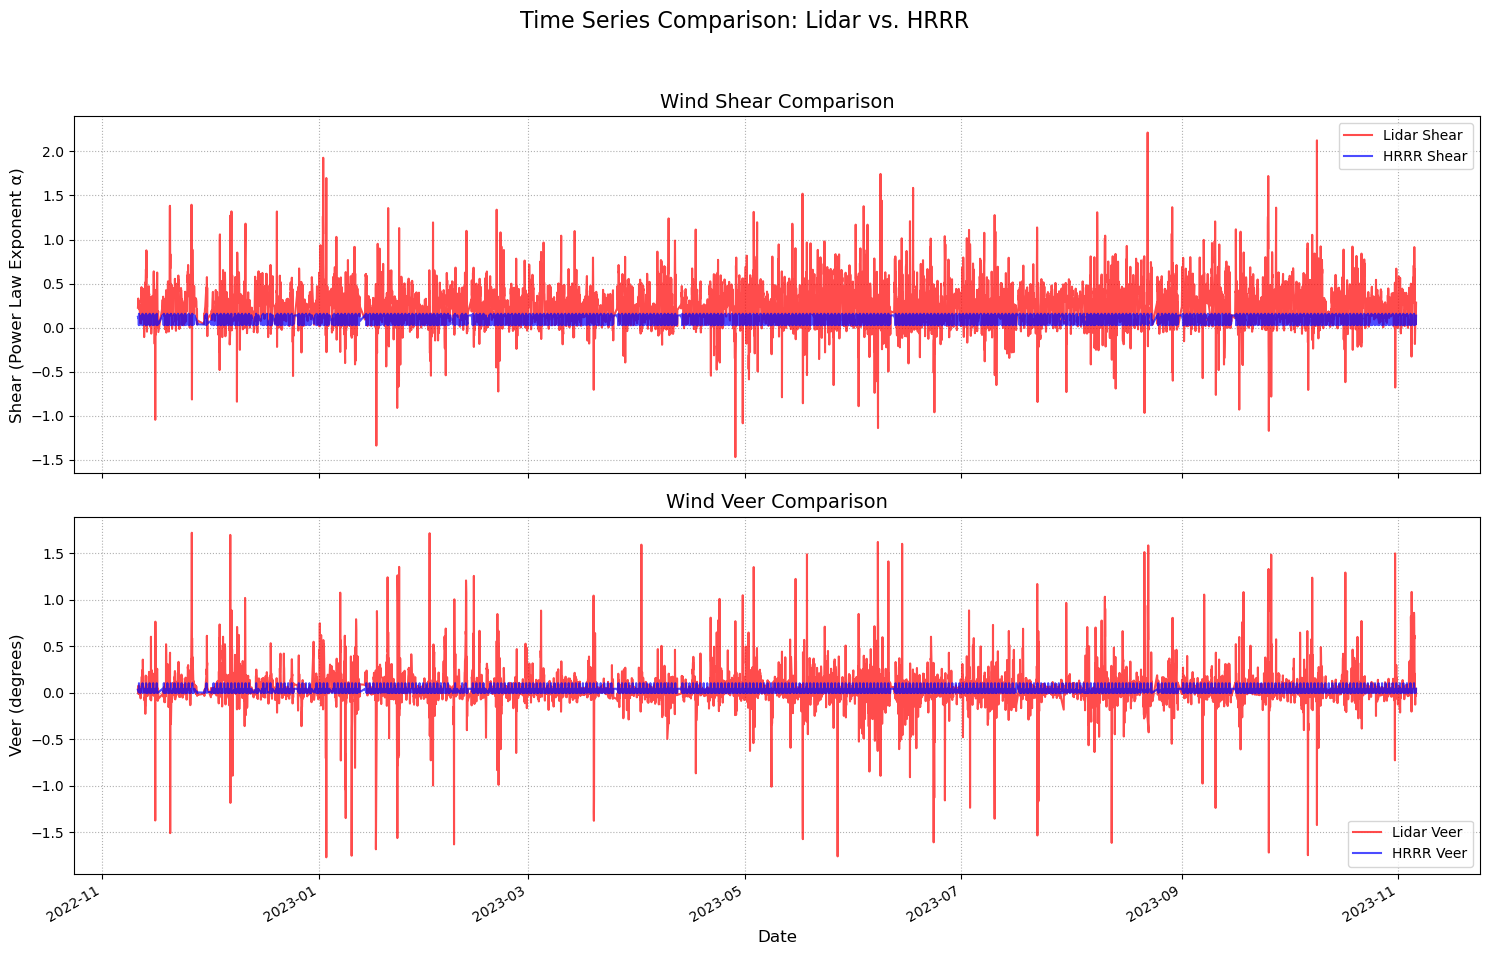

In [192]:
if not df_final_comparison.empty:
    print("\n--- Cell 6: Generating Comparison Time Series Plots ---")

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Time Series Comparison: Lidar vs. HRRR', fontsize=16)

    # Plot Shear Comparison
    axes[0].plot(df_final_comparison['time'], df_final_comparison['shear_lidar'], label='Lidar Shear', color='red', alpha=0.7)
    axes[0].plot(df_final_comparison['time'], df_final_comparison['shear_hrrr'], label='HRRR Shear', color='blue', alpha=0.7)
    axes[0].set_ylabel('Shear (Power Law Exponent α)', fontsize=12)
    axes[0].set_title('Wind Shear Comparison', fontsize=14)
    axes[0].grid(True, linestyle=':')
    axes[0].legend()

    # Plot Veer Comparison
    axes[1].plot(df_final_comparison['time'], df_final_comparison['veer_lidar'], label='Lidar Veer', color='red', alpha=0.7)
    axes[1].plot(df_final_comparison['time'], df_final_comparison['veer_hrrr'], label='HRRR Veer', color='blue', alpha=0.7)
    axes[1].set_ylabel('Veer (degrees)', fontsize=12)
    axes[1].set_title('Wind Veer Comparison', fontsize=14)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].grid(True, linestyle=':')
    axes[1].legend()

    # Formatting the x-axis for dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gcf().autofmt_xdate()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\n--- Cell 6: Skipping plot generation (no merged data) ---")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


       shear_lidar   shear_hrrr
count  7914.000000  7914.000000
mean      0.243621     0.085591
std       0.239523     0.038662
min      -1.468447     0.028403
25%       0.096578     0.045156
50%       0.227684     0.088190
75%       0.370792     0.112920
max       2.213179     0.157636
        veer_lidar    veer_hrrr
count  7914.000000  7914.000000
mean      0.051749     0.018933
std       0.201358     0.021819
min      -1.770000     0.000742
25%      -0.011000     0.003101
50%       0.033000     0.011755
75%       0.098000     0.025340
max       1.720000     0.102395

--- Cell 7: Generating Scatter Plots ---


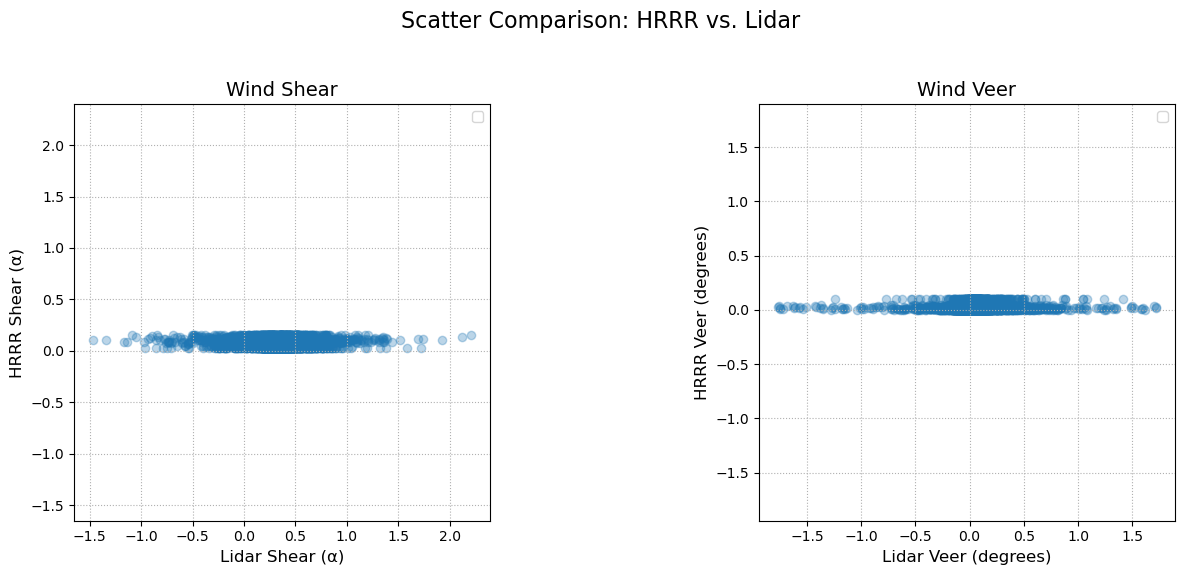

In [210]:
print(df_final_comparison[['shear_lidar', 'shear_hrrr']].describe())
print(df_final_comparison[['veer_lidar', 'veer_hrrr']].describe())



if not df_final_comparison.empty:
    print("\n--- Cell 7: Generating Scatter Plots ---")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Scatter Comparison: HRRR vs. Lidar', fontsize=16)

    # Shear Scatter Plot
    axes[0].scatter(df_final_comparison['shear_lidar'], df_final_comparison['shear_hrrr'], alpha=0.3)
    axes[0].set_xlabel('Lidar Shear (α)', fontsize=12)
    axes[0].set_ylabel('HRRR Shear (α)', fontsize=12)
    axes[0].set_title('Wind Shear', fontsize=14)
    # Add 1:1 line
    lims = [
        min(axes[0].get_xlim()[0], axes[0].get_ylim()[0]),
        max(axes[0].get_xlim()[1], axes[0].get_ylim()[1]),
    ]
    # axes[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='1:1 Line')
    axes[0].set_xlim(lims)
    axes[0].set_ylim(lims)
    axes[0].grid(True, linestyle=':')
    axes[0].legend()
    axes[0].set_aspect('equal', adjustable='box')


    # Veer Scatter Plot
    axes[1].scatter(df_final_comparison['veer_lidar'], df_final_comparison['veer_hrrr'], alpha=0.3)
    axes[1].set_xlabel('Lidar Veer (degrees)', fontsize=12)
    axes[1].set_ylabel('HRRR Veer (degrees)', fontsize=12)
    axes[1].set_title('Wind Veer', fontsize=14)
    # Add 1:1 line
    lims = [
        min(axes[1].get_xlim()[0], axes[1].get_ylim()[0]),
        max(axes[1].get_xlim()[1], axes[1].get_ylim()[1]),
    ]
    # axes[1].plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='1:1 Line')
    axes[1].set_xlim(lims)
    axes[1].set_ylim(lims)
    axes[1].grid(True, linestyle=':')
    axes[1].legend()
    axes[1].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\n--- Cell 7: Skipping plot generation (no merged data) ---")



--- Cell 8: Generating Diurnal Cycle Plots of Shear & Veer ---


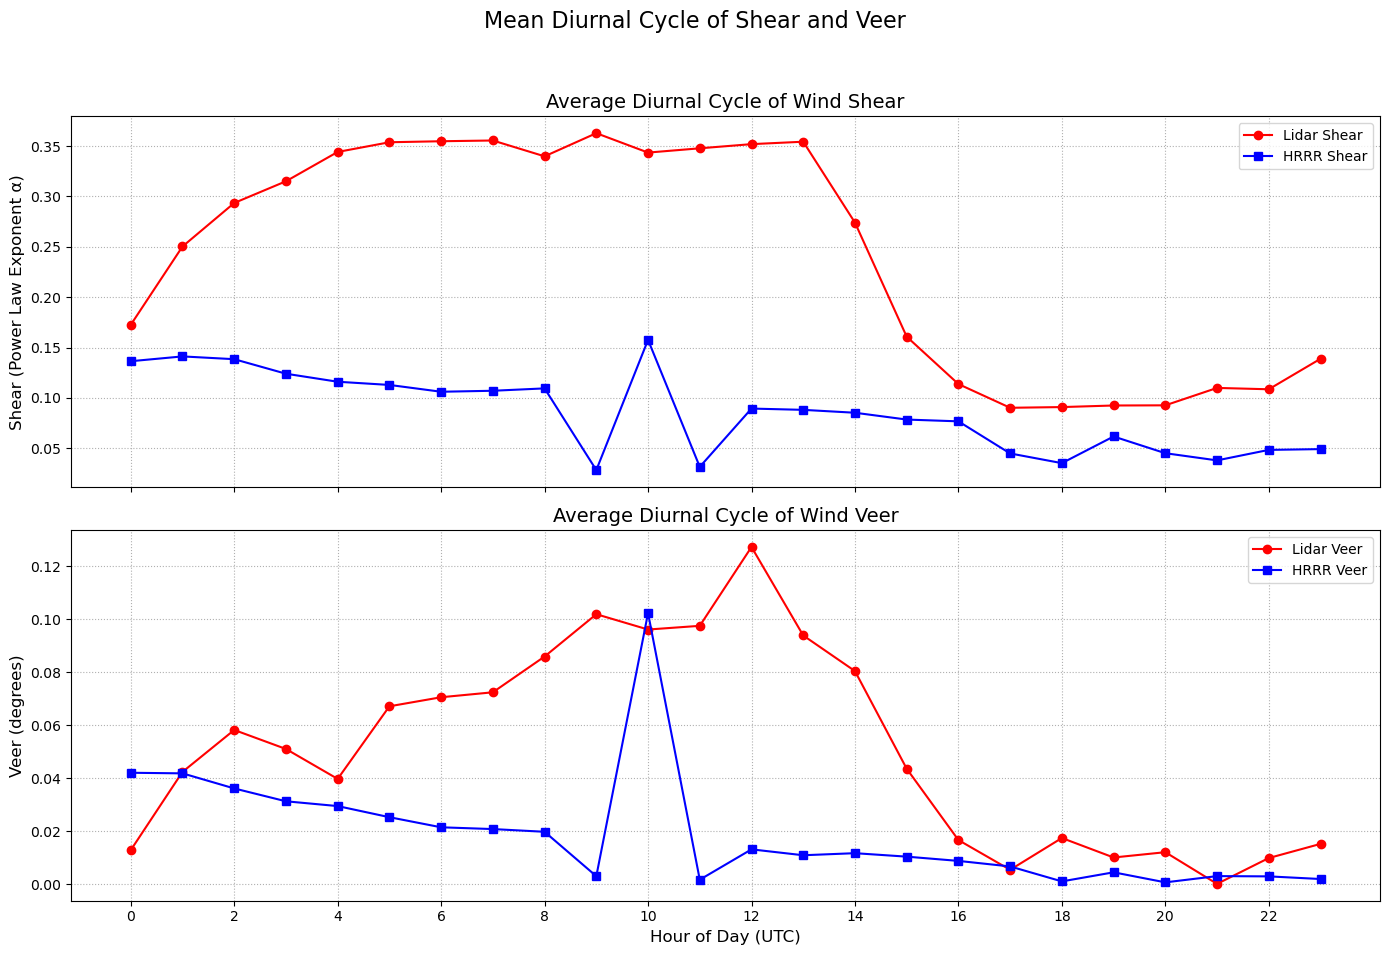

In [196]:
if not df_final_comparison.empty:
    print("\n--- Cell 8: Generating Diurnal Cycle Plots of Shear & Veer ---")
    
    # Extract hour of the day
    df_final_comparison['hour'] = df_final_comparison['time'].dt.hour
    
    # Group by hour and calculate the mean for each variable
    diurnal_avg = df_final_comparison.groupby('hour')[['shear_lidar', 'shear_hrrr', 'veer_lidar', 'veer_hrrr']].mean()
    
    # Create the plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    fig.suptitle('Mean Diurnal Cycle of Shear and Veer', fontsize=16)

    # Diurnal Shear Plot
    axes[0].plot(diurnal_avg.index, diurnal_avg['shear_lidar'], 'o-', label='Lidar Shear', color='red')
    axes[0].plot(diurnal_avg.index, diurnal_avg['shear_hrrr'], 's-', label='HRRR Shear', color='blue')
    axes[0].set_ylabel('Shear (Power Law Exponent α)', fontsize=12)
    axes[0].set_title('Average Diurnal Cycle of Wind Shear', fontsize=14)
    axes[0].grid(True, linestyle=':')
    axes[0].legend()

    # Diurnal Veer Plot
    axes[1].plot(diurnal_avg.index, diurnal_avg['veer_lidar'], 'o-', label='Lidar Veer', color='red')
    axes[1].plot(diurnal_avg.index, diurnal_avg['veer_hrrr'], 's-', label='HRRR Veer', color='blue')
    axes[1].set_xlabel('Hour of Day (UTC)', fontsize=12)
    axes[1].set_ylabel('Veer (degrees)', fontsize=12)
    axes[1].set_title('Average Diurnal Cycle of Wind Veer', fontsize=14)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].grid(True, linestyle=':')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\n--- Cell 8: Skipping plot generation (no merged data) ---")
